# Exploring the Best Steakhouses in New York City

**Introduction**
##### Hardly a number of cities in the US are synonymous with steak. But New York has been home to a line of steakhouses for centuries. And since then, new steakhouses have emerged to continue on with its legacy.  Local or visitor, a real Big Apple experience is putting yourself into one of these spots and digging in.

**Problem Description**
##### The City of New York has a rich heritage of steakhouses. From vintage classic spots to modern day steak joints, you will find a good restaurant in NYC that offer delicious cuts. But when we are talking about shedding an ample amount of cash on a single plate of meat, you will want the best.

##### So, as focus of this project, we will explore and visualize which neighborhoods and boroughs have the most, as well as the best Steakhouses in NYC.

**Target Audience:**
##### The objective of this study is to locate and recommend the best Steakhouses in the city of New York. This would interest locals, tourists, food bloggers or enthusiasts and anyone who would like to explore the best tasting steak joint in the city. Also, this study can serve as a good practice for those who want to develop their skills on Data Science. 

**Data Acquisition and Cleaning** 
##### For this project, we will utilize the following data:
##### New York City data that contains the list of boroughs, neighborhoods along with their latitude and longitude from https://cocl.us/new_york_dataset We will use this dataset to explore various neighborhoods of New York City.
##### Steakhouses in each neighborhood of New York City from Foursquare API. By using this API, we can get the up-to-date location data for each borough and neighborhood that contains Steakhouses. Venue details will also be obtained using this API.
##### GeoSpace data from https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqm j-j8zm This will provide us a better understanding of the neighborhoods and their corresponding locations in the folium map.

**Methodology**
##### Gather the New York City data from https://cocl.us/new_york_dataset. Using FourSquare API, we will filter the venues with Steakhouse category in the neighborhood. Find ratings, tips and like counts for each Steakhouse using FourSquare API. After acquring the ratings for each restaurant, we will then try to sort the data. Finally, we will visualize the findings using matplotlib and folium for better understanding.

##### The processing of these data will allow us to answer the following questions:
- Which borough and neighborhood have the highest rating of Steakhouse in NYC?
- Which borough has the most number of Steakhouse in NYC? 
- Which Steakhouse has the most number of likes and tips?
- Which Steakhouse has the highest rating in NYC?

**Exploratory Data Analysis**

##### Import all required libraries.

In [41]:
import pandas as pd
import numpy as np
import requests
import os
import json

import folium # For rendering maps

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # Acquiring latitude and longitude

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

print('Imported Libraries.')

Solving environment: done

# All requested packages already installed.

Imported Libraries.


In [42]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

In [43]:
df_ny = get_new_york_data()

In [44]:
df_ny.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [45]:
df_ny.shape

(306, 4)

##### Let's check if we can obtain data from a sample neighborhood.

In [46]:
df_ny[df_ny['Neighborhood']=='Financial District']

,Borough,Neighborhood,Latitude,Longitude
128,Manhattan,Financial District,40.707107,-74.010665


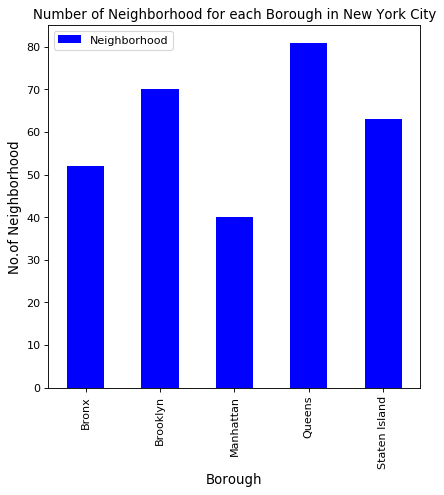

In [47]:
plt.figure(figsize=(6,6), dpi = 80)
# title
plt.title('Number of Neighborhood for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 12)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=12)
#giving a bar plot
df_ny.groupby('Borough')['Neighborhood'].count().plot(kind='bar', color='#0000FF')
#legend
plt.legend()
#displays the plot
plt.show()

In [48]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

In [61]:
CLIENT_ID = 'T40XENDN3XJ5G1UYUYXBEVTEGGMHABTPNRIH3ULFGDD00VGZ' # your Foursquare ID
CLIENT_SECRET = 'PVAL4GZ3ZRSEWEM13UH4ZQAG0ZIPNQGB5W1KJRAIA53ZEAKY' # your Foursquare Secret
VERSION = '20200709' # Foursquare API version

In [62]:
# In making these calls from Foursquare API, the category ID for Steakhouse (‘4bf58dd8d48988d1cc941735’) was used.
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=1000
    
    #url to fetch data from Foursquare API
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryID{}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT,
            '4bf58dd8d48988d1cc941735')
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [63]:
def get_venue_details(venue_id):
        
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

##### Let's use the sample neighorhood, Financial District, to check if there are steakhouses in that area.

In [64]:
vns = get_venues(40.707107,-74.010665)
vns[vns['Category']=='Steakhouse']

,ID,Name,Category
35,4ab27744f964a520486b20e3,Harry's Cafe and Steak,Steakhouse
83,51cac19e498e1f28926b8a8d,Morton's The Steakhouse,Steakhouse


In [65]:
stk_res = vns[vns['Category']=='Steakhouse'].values.tolist()
stk_res

[['4ab27744f964a520486b20e3', "Harry's Cafe and Steak", 'Steakhouse'],
 ['51cac19e498e1f28926b8a8d', "Morton's The Steakhouse", 'Steakhouse']]

In [66]:
len(vns[vns['Category']=='Steakhouse'].values.tolist()) > 0

True

In [67]:
for row in df_ny.values.tolist():
    print(row)

['Bronx', 'Wakefield', 40.89470517661, -73.84720052054902]
['Bronx', 'Co-op City', 40.87429419303012, -73.82993910812398]
['Bronx', 'Eastchester', 40.887555677350775, -73.82780644716412]
['Bronx', 'Fieldston', 40.89543742690383, -73.90564259591682]
['Bronx', 'Riverdale', 40.890834493891305, -73.9125854610857]
['Bronx', 'Kingsbridge', 40.88168737120521, -73.90281798724604]
['Manhattan', 'Marble Hill', 40.87655077879964, -73.91065965862981]
['Bronx', 'Woodlawn', 40.89827261213805, -73.86731496814176]
['Bronx', 'Norwood', 40.87722415599446, -73.8793907395681]
['Bronx', 'Williamsbridge', 40.88103887819211, -73.85744642974207]
['Bronx', 'Baychester', 40.866858107252696, -73.83579759808117]
['Bronx', 'Pelham Parkway', 40.85741349808865, -73.85475564017999]
['Bronx', 'City Island', 40.84724670491813, -73.78648845267413]
['Bronx', 'Bedford Park', 40.870185164975325, -73.8855121841913]
['Bronx', 'University Heights', 40.85572707719664, -73.9104159619131]
['Bronx', 'Morris Heights', 40.847897926

In [73]:
# prepare neighborhood list that contains Steakhouse
column_names=['Borough', 'Neighborhood', 'ID','Name']
steak_rest_ny=pd.DataFrame(columns=column_names)

print('Steakhouse in\n---------------------')
       
for row in df_ny.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    steak_restaurants=venues[venues['Category']=='Steakhouse']
    if len(steak_restaurants) > 0:
        print(Neighborhood+', '+Borough+' : '+str(len(steak_restaurants)))
    for restaurant_detail in steak_restaurants.values.tolist():
        id, name , category=restaurant_detail
        steak_rest_ny = steak_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)

print('Completed constructing the Steakhouse data set')

Steakhouse in
---------------------
Fieldston, Bronx : 1
Kingsbridge, Bronx : 1
Marble Hill, Manhattan : 1
Baychester, Bronx : 1
High  Bridge, Bronx : 1
Mott Haven, Bronx : 1
Hunts Point, Bronx : 1
Schuylerville, Bronx : 1
Manhattan Terrace, Brooklyn : 1
Kensington, Brooklyn : 1
Williamsburg, Brooklyn : 1
Starrett City, Brooklyn : 1
Bath Beach, Brooklyn : 1
Borough Park, Brooklyn : 1
Marine Park, Brooklyn : 1
South Side, Brooklyn : 1
Ocean Parkway, Brooklyn : 2
Fort Hamilton, Brooklyn : 1
East Harlem, Manhattan : 1
Midtown, Manhattan : 3
Murray Hill, Manhattan : 1
Tribeca, Manhattan : 2
West Village, Manhattan : 2
Battery Park City, Manhattan : 2
Financial District, Manhattan : 2
Long Island City, Queens : 1
College Point, Queens : 1
Bayside, Queens : 1
Oakland Gardens, Queens : 1
Steinway, Queens : 1
Bay Terrace, Queens : 1
Rockaway Park, Queens : 1
St. George, Staten Island : 1
New Brighton, Staten Island : 1
Travis, Staten Island : 1
Tompkinsville, Staten Island : 1
Arrochar, Staten

In [74]:
steak_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Fieldston,46e6f285f964a520c94a1fe3,Jake’s Steakhouse
1,Bronx,Kingsbridge,4dfe40df8877333e195b68fc,Parrilla Latina
2,Manhattan,Marble Hill,4dfe40df8877333e195b68fc,Parrilla Latina
3,Bronx,Baychester,560afe74498ec5e1b97a21a1,Outback Steakhouse
4,Bronx,High Bridge,4c0fd7a6f1b6a593b1ee7a27,NYY STEAK


In [75]:
steak_rest_ny.shape

(52, 4)

##### Using the FourSquare API, 52 Steakhouses in New York City were obtained.

In [76]:
steak_rest_ny.to_csv('steak_rest_ny.csv', index=False)

In [77]:
steak_rest_ny_csv=pd.read_csv('steak_rest_ny.csv')

##### Let us visualize the number of Steakhouses per Borough.

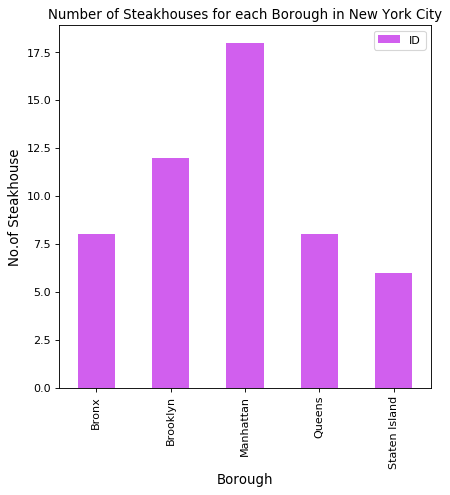

In [78]:
plt.figure(figsize=(6,6), dpi = 80)
# title
plt.title('Number of Steakhouses for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 12)
#On y-axis
plt.ylabel('No.of Steakhouse', fontsize=12)
#giving a bar plot
steak_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar', color='#D15FEE')
#legend
plt.legend()
#displays the plot
plt.show()

##### Due to limitation with the number of premium calls using Foursquare API, only 50 Steakhouses were processed among the 52. The two Steakhouses that were left were the data for T Fusion Steakhouse (Madison, Brooklyn) and M.Wells Steakhouse (Queensbridge, Queens).

In [79]:
# prepare neighborhood list that contains steakhouse
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
steak_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in steak_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(steak_rest_ny),')','processed')
    steak_rest_stats_ny = steak_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

                         ID               Name  Likes  Rating  Tips
0  46e6f285f964a520c94a1fe3  Jake’s Steakhouse     64     7.9    29
( 1 / 52 ) processed
                         ID             Name  Likes  Rating  Tips
0  4dfe40df8877333e195b68fc  Parrilla Latina      8     6.8     6
( 2 / 52 ) processed
                         ID             Name  Likes  Rating  Tips
0  4dfe40df8877333e195b68fc  Parrilla Latina      8     6.8     6
( 3 / 52 ) processed
                         ID                Name  Likes  Rating  Tips
0  560afe74498ec5e1b97a21a1  Outback Steakhouse     19     7.0     1
( 4 / 52 ) processed
                         ID       Name  Likes  Rating  Tips
0  4c0fd7a6f1b6a593b1ee7a27  NYY STEAK     41     8.0    12
( 5 / 52 ) processed
                         ID          Name  Likes  Rating  Tips
0  53dd7aaf498e6dfaddd17fcb  Don Pancho's     12     8.4     3
( 6 / 52 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for i

KeyError: 'venue'

In [80]:
steak_rest_stats_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Fieldston,46e6f285f964a520c94a1fe3,Jake’s Steakhouse,64,7.9,29
1,Bronx,Kingsbridge,4dfe40df8877333e195b68fc,Parrilla Latina,8,6.8,6
2,Manhattan,Marble Hill,4dfe40df8877333e195b68fc,Parrilla Latina,8,6.8,6
3,Bronx,Baychester,560afe74498ec5e1b97a21a1,Outback Steakhouse,19,7.0,1
4,Bronx,High Bridge,4c0fd7a6f1b6a593b1ee7a27,NYY STEAK,41,8.0,12


In [81]:
steak_rest_stats_ny.to_csv('steak_rest_stats_ny.csv', index=False)

In [82]:
steak_rest_stats_ny_csv=pd.read_csv('steak_rest_stats_ny.csv')

In [83]:
steak_rest_stats_ny_csv.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Fieldston,46e6f285f964a520c94a1fe3,Jake’s Steakhouse,64,7.9,29
1,Bronx,Kingsbridge,4dfe40df8877333e195b68fc,Parrilla Latina,8,6.8,6
2,Manhattan,Marble Hill,4dfe40df8877333e195b68fc,Parrilla Latina,8,6.8,6
3,Bronx,Baychester,560afe74498ec5e1b97a21a1,Outback Steakhouse,19,7.0,1
4,Bronx,High Bridge,4c0fd7a6f1b6a593b1ee7a27,NYY STEAK,41,8.0,12


In [84]:
steak_rest_stats_ny.shape

(50, 7)

In [85]:
steak_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       50 non-null     object 
 1   Neighborhood  50 non-null     object 
 2   ID            50 non-null     object 
 3   Name          50 non-null     object 
 4   Likes         50 non-null     object 
 5   Rating        50 non-null     float64
 6   Tips          50 non-null     object 
dtypes: float64(1), object(6)
memory usage: 2.9+ KB


In [86]:
convert_types = {'Likes': float,'Rating': float,'Tips': float}
steak_rest_stats_ny = steak_rest_stats_ny.astype(convert_types)
steak_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       50 non-null     object 
 1   Neighborhood  50 non-null     object 
 2   ID            50 non-null     object 
 3   Name          50 non-null     object 
 4   Likes         50 non-null     float64
 5   Rating        50 non-null     float64
 6   Tips          50 non-null     float64
dtypes: float64(3), object(4)
memory usage: 2.9+ KB


In [87]:
steak_rest_stats_ny.iloc[steak_rest_stats_ny['Likes'].idxmax()]

Borough                         Brooklyn
Neighborhood                Williamsburg
ID              3fd66200f964a5209beb1ee3
Name             Peter Luger Steak House
Likes                               1955
Rating                               8.7
Tips                                 676
Name: 10, dtype: object

In [88]:
steak_rest_stats_ny.iloc[steak_rest_stats_ny['Rating'].idxmax()]

Borough                        Manhattan
Neighborhood                West Village
ID              585164b77220e62219c9aeb6
Name                 4 Charles Prime Rib
Likes                                217
Rating                               9.4
Tips                                  57
Name: 27, dtype: object

In [89]:
steak_rest_stats_ny.iloc[steak_rest_stats_ny['Tips'].idxmax()]

Borough                         Brooklyn
Neighborhood                Williamsburg
ID              3fd66200f964a5209beb1ee3
Name             Peter Luger Steak House
Likes                               1955
Rating                               8.7
Tips                                 676
Name: 10, dtype: object

In [90]:
ny_borough_stats=steak_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']

In [91]:
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
2,Manhattan,8.444444
1,Brooklyn,7.781818
4,Staten Island,6.983333
0,Bronx,6.537500
3,Queens,6.528571


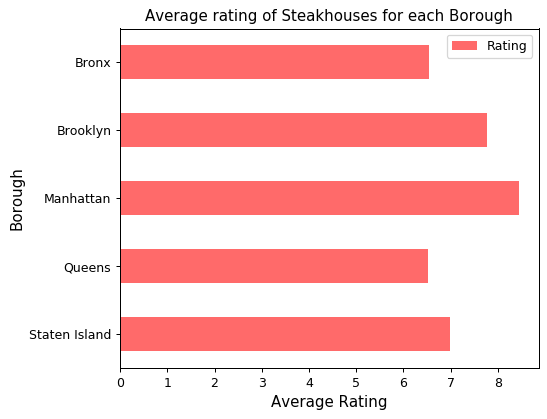

In [92]:
plt.figure(figsize=(6,5), dpi = 90)
# title
plt.title('Average rating of Steakhouses for each Borough')
#On x-axis
plt.ylabel('Borough', fontsize = 12)
#On y-axis
plt.xlabel('Average Rating', fontsize=12)
#giving a bar plot
steak_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='barh', color='#FF6A6A')
#legend
plt.legend()
#displays the plot
plt.gca().invert_yaxis()
plt.show()

##### List of neighborhood with average rating of Steakhouses greater than or equal to 8.5

In [93]:
ny_neighborhood_stats=steak_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']

In [94]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=8.5]

In [95]:
ny_neighborhood_stats

,Neighborhood,Average Rating
5,Bayside,8.500000
22,Midtown,8.733333
23,Midtown South,8.800000
25,Murray Hill,8.500000
29,Rockaway Park,8.700000
31,South Side,8.700000
35,Sutton Place,8.550000
38,Tribeca,8.550000
40,West Village,9.100000
41,Williamsburg,8.700000


In [96]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,df_ny, on='Neighborhood')

In [97]:
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]

In [98]:
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Queens,Bayside,40.766041,-73.774274,8.500000
1,Manhattan,Midtown,40.754691,-73.981669,8.733333
2,Manhattan,Midtown South,40.748510,-73.988713,8.800000
3,Manhattan,Murray Hill,40.748303,-73.978332,8.500000
4,Queens,Murray Hill,40.764126,-73.812763,8.500000
5,Queens,Rockaway Park,40.580343,-73.841534,8.700000
6,Brooklyn,South Side,40.710861,-73.958001,8.700000
7,Manhattan,Sutton Place,40.760280,-73.963556,8.550000
8,Manhattan,Tribeca,40.721522,-74.010683,8.550000
9,Manhattan,West Village,40.734434,-74.006180,9.100000


In [99]:
# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)

In [100]:
incidents = folium.map.FeatureGroup()

for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='#EA1253',
            fill=True,
            fill_color='#12EA92',
            fill_opacity=0.4
        )
    )

In [101]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'

In [102]:
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

**Conclusion**
##### Manhattan has the most number of Steakhouses in New York City per borough. They also have the highest average rating of Steakhouses. There are six neighborhoods in Manhattan with >=8.5 average rating of Steakhouses.
##### The Steakhouse with the highest rating is 4 Charles Prime Rib located at the Manhattan borough. Interestingly, the Steakhouse with the most number of likes and tips is Peter Luger Steakhouse located in Brooklyn.